In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from coil_geometry import create_homo_geometry
import matplotlib.pyplot as plt
import numpy as np 
import os
import time

In [2]:
start_time = time.time()

In [3]:
nwindings = 6  # Number of windings
wireradius = 0.001  # Radius of the wire
coilradius = 0.01  # Radius of the coil

# Geometrie laden
geo,_ = create_homo_geometry(nwindings, wireradius, coilradius)

In [4]:
mesh = Mesh(
geo.GenerateMesh(grading=0.2)
)
mesh.Curve(1) 

In [5]:
print("Materialien im Mesh:", mesh.GetMaterials())
print("Randbedingungen im Mesh:", mesh.GetBoundaries())

Materialien im Mesh: ('coil', 'air')
Randbedingungen im Mesh: ('default', 'default', 'default', 'default', 'outer', 'outer', 'outer', 'outer', 'outer', 'outer')


In [6]:
# Konstanten
mu = 4 * pi * 1e-7      # Magnetische Feldkonstante (S.2)
sigma_coil = 5.87e7     # Leitfähigkeit Kupfer (S.11)
sigma_air = 0           # Leitfähigkeit Luft
k = 0.1                 # Regularisierungfaktor -> ev. ploten für vergleich für gcsolver good/notgood
i_c = 500               # Strom [A]

# Geometrische Parameter
A_c = pi * wireradius**2  
A_c = nwindings*(2*wireradius)*1.2*2*wireradius
r = sqrt(x**2 + y**2) # radius von coil 

# Stromdichte j_c gemäß Aufgabenstellung
j_c = CoefficientFunction((
    (nwindings * i_c / A_c) * y / r,
    -(nwindings * i_c / A_c) * x / r,
    0
))

In [7]:
# H(curl)-Raum definieren
order = 4
V = HCurl(mesh, order=order-1, nograds=True, dirichlet="outer")
u, v = V.TnT()
gfA = GridFunction(V)


# Bilinearform und Linearform
a = BilinearForm(V, symmetric=True)
a += (1/mu) * InnerProduct(curl(u), curl(v)) * dx
a += k * InnerProduct(u, v) * dx

# Preconditioner
pre = Preconditioner(a, "bddc")

# Linearform: Stromdichte
f = LinearForm(V)
f += InnerProduct(j_c, v) * dx("coil")

# Assemble
with TaskManager():
    a.Assemble()
    f.Assemble()

In [8]:
# Grösse von Gleichungsystems Elemente überprüfen
print(f"Matrix size: {a.mat.height} x {a.mat.width}")
print(f"Vector size: {f.vec.size}")
print(f"Präkonditionierer-Matrixgröße: {pre.mat.height} x {pre.mat.width}")

Matrix size: 1250320 x 1250320
Vector size: 1250320
Präkonditionierer-Matrixgröße: 1250320 x 1250320


In [9]:
# Lösen des Gleichungssystems mit CG-Verfahren und Präkonditionierer (krylovspace.CGSolver)
inv = krylovspace.CGSolver(a.mat, pre.mat, tol=1e-12, printrates = True)

with TaskManager():
    gfA.vec.data = inv * f.vec

CG iteration 1, residual = 178.56745695930863     
CG iteration 2, residual = 4.67684537595603     
CG iteration 3, residual = 6.264590682517702     
CG iteration 4, residual = 4.382403042708366     
CG iteration 5, residual = 3.0522689595565917     
CG iteration 6, residual = 1.8884197726636813     
CG iteration 7, residual = 0.9890820532531475     
CG iteration 8, residual = 0.5938843653668442     
CG iteration 9, residual = 0.41324975482646154     
CG iteration 10, residual = 0.25719898263815827     
CG iteration 11, residual = 0.18125588423474828     
CG iteration 12, residual = 0.150773972534582     
CG iteration 13, residual = 0.14287620400304718     
CG iteration 14, residual = 0.11102807492207098     
CG iteration 15, residual = 0.08489193033897335     
CG iteration 16, residual = 0.060332218497335686     
CG iteration 17, residual = 0.040868706173742914     
CG iteration 18, residual = 0.025235146748537825     
CG iteration 19, residual = 0.015212158892633713     
CG iteration

In [10]:
# Calculate the residual manually
residual_vec = f.vec - a.mat * gfA.vec
residual_norm = residual_vec.Norm()
print(f"Residual norm: {residual_norm}")

Residual norm: 154.95132665014035


In [11]:
B = curl(gfA)

In [12]:
# Feldlinien to be done 
yiB = np.linspace(-.005,.005,9)
XiB, YiB = np.meshgrid(yiB,yiB)
fieldlines = B._BuildFieldLines(mesh, np.array([XiB.flatten(),
    YiB.flatten(),np.zeros_like(XiB.flatten())]).T,
    num_fieldlines=10**3//5, randomized=False,
    length=1.,thickness=8e-4)
Draw (B, mesh.Materials('coil'), objects=[fieldlines],
      draw_surf=False,
      min=0, max=0.1,
      settings={"Objects": {"Edges": False, "Surface": True,
                            "Wireframe": False}})


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Edges': False, …

BaseWebGuiScene

In [13]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Die Ausführung hat {elapsed_time:.2f} Sekunden gedauert.")

Die Ausführung hat 14.76 Sekunden gedauert.


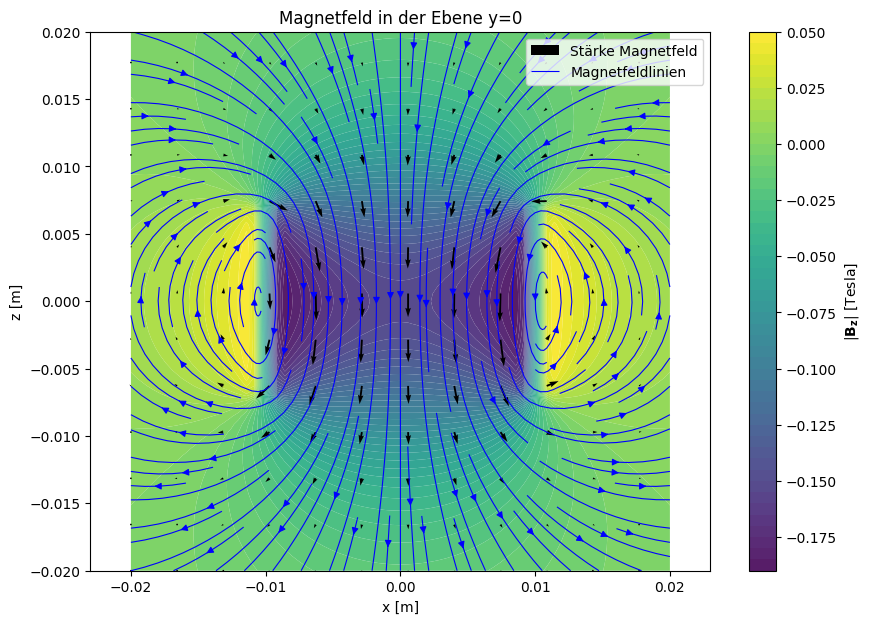

In [14]:
# Anzahl der Punkte im Gitter
nx = 71
nz = 71
lim = 0.02
xvals = np.linspace(-lim, lim, nx)
zvals = np.linspace(-lim, lim, nz)

# Meshgrid anlegen, für (X,Z)
X, Z = np.meshgrid(xvals, zvals)

# Arrays für Bx (U), Bz (V) und Magnetfeldstärke (Mag) anlegen
U = np.zeros_like(X)
V = np.zeros_like(X)
Mag = np.zeros_like(X)  # Betrag des Magnetfelds
Bz = np.zeros_like(X)  # Für Bz-Komponente

# Schleife über Gitterpunkte und Magnetfeld auswerten
for i in range(nz):
    for j in range(nx):
        x = X[i, j]
        z = Z[i, j]

        B_val = B(mesh(x, 0, z))  # B_val enthält (Bx, By, Bz)
        U[i, j] = B_val[0]       # x-Komponente
        V[i, j] = B_val[2]       # z-Komponente
        Bz[i, j] = B_val[2]      # z-Komponente
        Mag[i, j] = np.sqrt(B_val[0]**2 + B_val[2]**2)  # Betrag des Magnetfelds

# Schrittweite für Pfeildichte
step = 6
X_sparse = X[::step, ::step]
Z_sparse = Z[::step, ::step]
U_sparse = U[::step, ::step]
V_sparse = V[::step, ::step]
# Export plot as A4 PDF
Mag_sparse = Mag[::step, ::step]

# Plot erstellen
plt.figure(figsize=(10, 7))
plt.title("Magnetfeld in der Ebene y=0")

# Farbkontur basierend auf Magnetfeldbetrag
cont = plt.contourf(X, Z, Bz, levels=50, cmap="viridis", alpha=0.9, antialiased=True)
plt.colorbar(cont, label="$|\\mathbf{B_z}|$ [Tesla]")

# Pfeile für Magnetfeldrichtung und -stärke
plt.quiver(X_sparse, Z_sparse, U_sparse, V_sparse, color='k', scale=4, width=0.003, label='arrow')

# Magnetfeldlinien 
plt.streamplot(X, Z, U, V, color='b', density=1.3, linewidth=0.8)

# Layout
plt.axis('equal')
plt.xlabel("x [m]")
plt.ylabel("z [m]")

# Fix for legend
plt.legend(["Stärke Magnetfeld", "Magnetfeldlinien"], loc='upper right')

plt.show()

# Exports

In [15]:
import os
project_directory = os.getcwd()
i_c_str = str(i_c)

target_folder_name = "results/homo/" + i_c_str  # Name of the folder to check/create

target_folder_path = os.path.join(project_directory, target_folder_name)

# Check if the folder exists
if not os.path.exists(target_folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(target_folder_path)
    os.makedirs(target_folder_path + "/results")
    os.makedirs(target_folder_path + "/plot")
    print(f"Folder '{target_folder_name}' created.")
else:
    # Skip creation if it exists
    print(f"Folder '{target_folder_name}' already exists, skipping creation.")

Folder 'results/homo/500' already exists, skipping creation.


In [16]:
override = 1
ord_str = str(order)
ampere_dir = "results/homo/" + i_c_str
filename_gfA    = ampere_dir + "/results/gfA_homo_" + i_c_str + "_" + ord_str + "ord.vec"
filename_mesh   = ampere_dir + "/results/mesh_homo_" + i_c_str + "_" + ord_str + "ord.vol"

if override == 1:
    gfA.Save(filename_gfA)
    
    ngmesh = mesh.ngmesh
    ngmesh.Save(filename_mesh)
    
    print(" ########################### ")
    print(" ------ Results saved ------ ")
    print(" ########################### ")
else:
    print(" ########################### ")
    print(" ---- Results not saved ---- ")
    print(" ########################### ")

 ########################### 
 ------ Results saved ------ 
 ########################### 


In [17]:
override = 1

filename_magnetfeld_plot   = ampere_dir + "/plot/field_homo_plot" + i_c_str + "_" + ord_str + "ord.pdf"

if override == 1:
    # Plot erstellen
    plt.figure(figsize=(10, 7))
    plt.title("Magnetfeld in der Ebene y=0")

    # Farbkontur basierend auf Magnetfeldbetrag
    cont = plt.contourf(X, Z, Bz, levels=50, cmap="viridis", alpha=0.9, antialiased=True)
    plt.colorbar(cont, label="$|\\mathbf{B_z}|$ [Tesla]")

    # Pfeile für Magnetfeldrichtung und -stärke
    plt.quiver(X_sparse, Z_sparse, U_sparse, V_sparse, color='k', scale=4, width=0.003, label='arrow')

    # Magnetfeldlinien 
    plt.streamplot(X, Z, U, V, color='b', density=1.3, linewidth=0.8)

    # Layout
    plt.axis('equal')
    plt.xlabel("x [m]")
    plt.ylabel("z [m]")

    # Fix for legend
    plt.legend(["Stärke Magnetfeld", "Magnetfeldlinien"], loc='upper right')
    plt.savefig(filename_magnetfeld_plot, format='pdf', bbox_inches='tight')
    plt.close()
    
    print(" ########################### ")
    print(" ------ Plot saved ------ ")
    print(" ########################### ")
else:
    print(" ########################### ")
    print(" ---- Plot not saved ---- ")
    print(" ########################### ")

 ########################### 
 ------ Plot saved ------ 
 ########################### 


In [18]:
override = 1

filename_magnetfeld_3d   = ampere_dir + "/plot/field_homo_3d_" + i_c_str + "_" + ord_str + "ord.html"

if override == 1:
  Draw (B, mesh.Materials('coil'), objects=[fieldlines],
      draw_surf=False,
      min=0, max=0.1,
      settings={"Objects": {"Edges": False, "Surface": True,
                            "Wireframe": False}},
      filename=filename_magnetfeld_3d)

  print(" ########################### ")
  print(" ------ Plot saved ------ ")
  print(" ########################### ")
else:
  print(" ########################### ")
  print(" ---- Plot not saved ---- ")
  print(" ########################### ")

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Edges': False, …

 ########################### 
 ------ Plot saved ------ 
 ########################### 


In [19]:
x, y, z = 0, 0, 0
point = mesh(x, y, z)
B_at_point = B(point) 
betrag = sqrt(B_at_point[0]**2+B_at_point[1]**2+B_at_point[2]**2)
print(f"{B_at_point}")
print(f"{betrag}")

(2.1578868436878703e-06, -7.44505879967043e-07, -0.1524109740861717)
0.15241097410326618


In [29]:
# Anzahl der Punkte
n_points = 1000

# Bounding Box des Meshes

bbox_min = np.array([-0.05, -0.05, -0.05])  # Untere Grenzen [x_min, y_min, z_min]
bbox_max = np.array([0.05, 0.05, 0.05])  # Obere Grenzen [x_max, y_max, z_max]

# Zufällige Punkte innerhalb der Bounding Box generieren
random_points = np.random.uniform(low=bbox_min, high=bbox_max, size=(n_points, 3))

# Punkte speichern, um sie in anderen Scripten wiederzuverwenden
np.save("random_points.npy", random_points)  # Punkte in Datei speichern

# Magnetfeld an den zufälligen Punkten berechnen
B_values = []
for point in random_points:
    try:
        B_val = B(mesh(*point))  # Magnetfeld an der Stelle 'point'
        B_values.append(np.linalg.norm(B_val))  # Betrag des Magnetfeldes
    except:
        print(f"Punkt {point} liegt außerhalb des Meshes und wird ignoriert.")

# Mittelwert berechnen
B_values = np.array(B_values)
np.save("B_values_homo.npy", B_values)